In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.cluster import homogeneity_score
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn import metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report, adjusted_rand_score, mutual_info_score, homogeneity_score, davies_bouldin_score, v_measure_score, completeness_score
import time
import math
import random
from sklearn.model_selection import train_test_split
from numpy.linalg import inv                    # for matrix inverse
from scipy.stats import multivariate_normal
from sklearn import mixture
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import FeatureAgglomeration as FA
from scipy.stats import kurtosis
from sklearn.preprocessing import normalize

import torch
import time
import torch.nn as nn  #allthe nn modules
import torch.optim as optim #optimization algorithms Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
import torchvision 
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

def purity_score(y_true, y_pred):
    contingency_matrix=metrics.cluster.contingency_matrix(y_true,y_pred)
    return np.sum(np.amax(contingency_matrix,axis=0))/np.sum(contingency_matrix)

In [2]:
class DataProcess:
 
    #def __init__(self,name):
    #    self.name=name

    def get_data(self,data_set):
        if data_set==1: #simulated
            size=200
            dimension=100
            clusters=5
            data_set=[]
            for i in range(size):
                for k in range(clusters):
                    mn=(2+k)*np.ones(dimension)
                    arr=.1*np.ones(dimension)
                    cov=np.diag(arr)
                    x=np.random.multivariate_normal(mn, cov, 1)
                    temp=x[0].tolist()
                    temp.append(k)
                    data_set.append(temp)

            df=pd.DataFrame(data=data_set)  
            y=df[dimension]
            X=df.drop(dimension,axis=1)
            sc=StandardScaler()
            sc.fit(X)
            scaled_data=sc.transform(X)
            
        elif data_set==2: #titanic
                 #titanic
            df=pd.read_csv("dataSets/titanic.csv")
            del df["PassengerId"]
            del df["Name"]
            del df["Ticket"]
            del df["Cabin"]
            df['Sex']=df['Sex'].replace(to_replace='male',value='1')
            df['Sex']=df['Sex'].replace(to_replace='female',value='0')
            df['Embarked']=df['Embarked'].replace(to_replace='S',value='0')
            df['Embarked']=df['Embarked'].replace(to_replace='C',value='1')
            df['Embarked']=df['Embarked'].replace(to_replace='Q',value='2')
            #now with extraneous columns deleted and categorical data data converted to integers, I'll delete all rows with corrupting NaN values
            df=df.dropna()
            df.head()
            y=df['Survived']
            X=df.drop('Survived',axis=1) 
            #mms = MinMaxScaler()
            #mms.fit(X)
            #scaled_data =mms.transform(X)    
            return X, y

            
        elif data_set==3:
            #diabetes
            df=pd.read_csv("dataSets/diabetes.csv")
            zero_to_nan=['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
            for col in zero_to_nan:
                df[col]=df[col].replace(0,np.NaN)
                mean=int(df[col].mean(skipna=True))
                df[col]=df[col].replace(np.NaN,mean)
                X=df.drop('Outcome',axis=1)
                y=df['Outcome']
                sc=StandardScaler()
                sc.fit(X)
                scaled_data=sc.transform(X)

        return scaled_data, y    
     
    def dimReduction(self,scaled_data, red_type, dims, max_iterations, toler):
        #pca 1, ica 2, ran 3, fa 4
        dim=dims
        if red_type==1:
            pca=PCA(n_components=dim)
            pca.fit(scaled_data)
            data=pca.transform(scaled_data)
 
        elif red_type==2:
            ica=FastICA(n_components=dim, max_iter=max_iterations, tol=toler)  #use 1000 and .1 for sim data set
            data = ica.fit_transform(scaled_data)   

        elif red_type==3:
            if isinstance(scaled_data, pd.DataFrame):
                X=scaled_data
                mms = MinMaxScaler()
                mms.fit(X)
                scaled_data =mms.transform(X)   
            
            original_features=len(scaled_data[0])
 
            new_features=dim

            R=np.random.normal(0,1/new_features,[original_features,new_features])
            R_normed = normalize(R, axis=0, norm='l2')
            data=np.matmul(scaled_data,R_normed)

        elif red_type==4:
            fa = FA(n_clusters = dim)
            data = fa.fit_transform(scaled_data)
        else:
            print("input error")
            return 1
        
        return data
        
    def KmeansOutput(self,X, y,plot_title, proj_type):
        ari=[]
        SSD = []
        sil_score=[]
        mi=[]
        homo=[]
        comp=[]
        v=[]
        davies=[]
        clusters=range(2,20)
        mms = MinMaxScaler()
        mms.fit(X)
        scaled_data =mms.transform(X)    
        for c in clusters:
            km = KMeans(n_clusters=c)
            km = km.fit(scaled_data)
            SSD.append(km.inertia_)

            labels=cluster.KMeans(n_clusters=c).fit(X).labels_
            sil_score.append(metrics.silhouette_score(X,labels,metric="euclidean",sample_size=100))

            pred = km.predict(scaled_data)
            ari.append(adjusted_rand_score(y, pred))
            mi.append(mutual_info_score(y,pred))
            homo.append(homogeneity_score(y,pred))
            comp.append(completeness_score(y,pred))
            v.append(v_measure_score(y,pred))            
            davies.append(davies_bouldin_score(scaled_data, labels))
             
        
        plt.subplots(figsize=(14, 3))

        plt.subplot(1, 6, 1) # row 1, col 2 index 1
        plt.plot(clusters, SSD, 'bx-')
        plt.xlabel('Clusters (KMeans)')
        plt.ylabel('Sum_of_squared_distances')
        plt_title=('Elbow Method For Optimal k \n'+plot_title+" "+proj_type)
        plt.title(plt_title)
        
        plt.subplot(1, 6, 2) # index 2
        plt.plot(clusters, davies, 'bx-')
        plt.xlabel('Clusters (KMeans)')
        plt.ylabel('Davies-Bouldin Score')
        plt.title('Davies-Bouldin vs k \n'+plot_title+" "+proj_type)
        plt.tight_layout(pad=1.0)

        plt.subplot(1, 6, 3) # row 1, col 2 index 1
        plt.plot(clusters, ari, 'bx-')
        plt.xlabel('Clusters (KMeans)')
        plt.ylabel('ARI Score')
        plt.title('ARI Score vs k \n'+plot_title+" "+proj_type)

        plt.subplot(1, 6, 4) # index 2
        plt.plot(clusters, mi, 'bx-')
        plt.xlabel('Clusters (KMeans)')
        plt.ylabel('Mutual Information Score')
        plt.title('Mutual Information Score vs k \n'+plot_title+" "+proj_type)

        plt.subplot(1, 6, 5) # index 2
        plt.plot(clusters, sil_score, 'bx-')
        plt.xlabel('Clusters (KMeans)')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Score vs k\n'+plot_title+" "+proj_type)  

        plt.subplot(1, 6, 6) # index 2
        plt.plot(clusters, homo,color='blue')
        plt.plot(clusters, comp, 'red')
        plt.plot(clusters,v, color='green')
        plt.xlabel('Clusters (KMeans)')
        plt.ylabel('Homogeneity Score')
        plt.title('Homo, Comp, V vs k \n'+plot_title+" "+proj_type)
        plt.legend(["homo" , "comp","v-measure"])

        plt.show() 
                
    def EMOutput(self, scaled_data,y,plot_title, proj_type):
        ari=[]
        aic =[]
        bic=[]
        log_l=[]
        sil_score=[]
        mi=[]
        homo=[]
        comp=[]
        v=[]
        davies=[]
        clusters=range(3,20)

        for c in clusters:
            em=mixture.GaussianMixture(n_components=c, covariance_type='full',max_iter=1000,init_params='kmeans')
            em.fit(scaled_data)
            pred=em.predict(scaled_data)    
            sil_score.append(metrics.silhouette_score(scaled_data,pred,metric="euclidean",sample_size=100))
            log_l.append(em.score(scaled_data))
            aic.append(em.aic(scaled_data))
            bic.append(em.bic(scaled_data))
            ari.append(adjusted_rand_score(y, pred))
            mi.append(mutual_info_score(y,pred))
            homo.append(homogeneity_score(y,pred))
            comp.append(completeness_score(y,pred))
            v.append(v_measure_score(y,pred))           
            davies.append(davies_bouldin_score(scaled_data, pred)) 
            
        plt.subplots(figsize=(14, 3))

        plt.subplot(1, 6, 1) # index 2
        plt.plot(clusters, aic, 'bx-')
        plt.xlabel('Clusters (EM)')
        plt.ylabel('AIC Score')
        plt.title('AIC vs K \n'+plot_title+" "+proj_type)
        plt.tight_layout(pad=1.0)


        plt.subplot(1, 6, 2) # index 2
        plt.plot(clusters, davies, 'bx-')
        plt.xlabel('Clusters (EM)')
        plt.ylabel('Davies-Bouldin Score')
        plt.title('Davies-Bouldin vs k \n'+plot_title+" "+proj_type)
        plt.tight_layout(pad=1.0)


        plt.subplot(1, 6, 3) # row 1, col 2 index 1
        plt.plot(clusters, ari, 'bx-')
        plt.xlabel('Clusters (EM)')
        plt.ylabel('ARI Score')
        plt.title('ARI Score vs k \n'+plot_title+" "+proj_type)


        plt.subplot(1, 6, 4) # index 2
        plt.plot(clusters, mi, 'bx-')
        plt.xlabel('Clusters (EM)')
        plt.ylabel('Mutual Information Score')
        plt.title('MI Score vs k \n'+plot_title+" "+proj_type)

        plt.subplot(1, 6, 5) # index 2
        plt.plot(clusters, sil_score, 'bx-')
        plt.xlabel('Clusters (EM)')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Score vs k \n'+plot_title+" "+proj_type)  

        plt.subplot(1, 6, 6) # index 2
        plt.plot(clusters, homo,color='blue')
        plt.plot(clusters, comp, 'red')
        plt.plot(clusters,v, color='green')
        plt.xlabel('Clusters (EM)')
        plt.ylabel('Homogeneity Score')
        plt.title('Homo, Comp, V vs k \n'+plot_title+" "+proj_type)
        plt.legend(["homo" , "comp","v-measure"])


        plt.show() 

            

In [6]:
class NeuralNetwork:
    def __init__(self, X,y):
        self.X = X
        self.y=y
        
        
    def run_NN(self,ninput, nhidden):
        def acc_func(y_pred,y_train):
                correct=0
                total=0
                TP=0
                FP=0
                TN=0
                FN=0
                for i in range(y_pred.size()[0]):
                    m=y_pred[i].float()
                    t=y_train[i].item()
                    if m<.5:
                        rounded=0
                    else:
                        rounded=1
                    if t>0 and (rounded-t)==0:
                        TP=TP+1
                    if t==0 and (rounded-t)==0:
                        TN=TN+1
                    if t>0 and (rounded-t)!=0:
                        FN=FN+1
                    if t==0 and (rounded-t)!=0:
                        FP=FP+1    
                    total+=1    
                accuracy=(TP+TN)/(TP+TN+FN+FP)
                return accuracy      
    
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size = 0.25, random_state = 25)
        sc_X=StandardScaler()
        X_train=sc_X.fit_transform(X_train)
        X_test=sc_X.fit_transform(X_test)
        X_train=torch.tensor(X_train)
        y_train=torch.tensor(y_train.astype(float).values)  #this is still a data frame
        X_test=torch.tensor(X_test)
        y_test=torch.tensor(y_test.astype(float).values)
        y_train=torch.reshape(y_train,(X_train.size()[0],1))
        y_test=torch.reshape(y_test,(X_test.size()[0],1))     
#        n_input, n_hidden, n_out, batch_size, learning_rate = 7, 5, 1, X_train.size()[0], 0.01
        n_out, batch_size, learning_rate = 1, X_train.size()[0], 0.01
        n_input, n_hidden=ninput, nhidden  

        model = nn.Sequential(  #Sequential lives inside the nueral network class
                      nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())

        losses=[]
        losses_test=[]
        accuracy=[]
        accuracy_test=[]
        optim=torch.optim.SGD(model.parameters(),learning_rate)
        tic = time.perf_counter()
        for i in range(10000):
            y_pred=model(X_train.float())
            y_pred_test=model(X_test.float())
            loss=sum((y_pred-y_train)**2)/y_train.shape[0]
            loss_test=sum((y_pred_test-y_test)**2)/y_test.shape[0]
            acc=acc_func(y_pred,y_train)
            acc_test=acc_func(y_pred_test,y_test)
            accuracy.append(acc)
            accuracy_test.append(acc_test)
            losses.append(loss.item())
            losses_test.append(loss_test.item())
            loss.backward()
            optim.step()
            optim.zero_grad()

        toc = time.perf_counter()
        print(f"Producing best fit model for NN {toc - tic:0.4f} seconds")
        
        correct=0
        total=0
        TP=0
        FP=0
        TN=0
        FN=0
        for i in range(X_train.size()[0]):
            m=model(X_train[i].float())[0].item()
            t=y_train[i].item()
            if m<.5:
                rounded=0
            else:
                rounded=1
            if t>0 and (rounded-t)==0:
                TP=TP+1
            if t==0 and (rounded-t)==0:
                TN=TN+1
            if t>0 and (rounded-t)!=0:
                FN=FN+1
            if t==0 and (rounded-t)!=0:
                FP=FP+1    
            total+=1    

        print("accuracy: ",(TP+TN)/(TP+TN+FN+FP))
        recall=TP/(FN+TP)
        prec=TP/(FP+TP)
        print("f1_score: ",2*(recall*prec)/(recall+prec))        
        plt.plot(losses, color="y",
        label="Training Data")
        plt.plot(losses_test, color="b",
        label="Testing Data")
        plt.grid()
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title("Learning rate %f"%(learning_rate))
        plt.legend(loc="best")
        plt.show()   
        
        plt.plot(accuracy, color="y",
        label="Training Data")
        plt.plot(accuracy_test, color="b",
        label="Testing Data")

        plt.grid()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title("Titanic Learning Curve Neural Network")
        plt.legend(loc="best")
        plt.show()  


Producing best fit model for NN 183.0430 seconds
accuracy:  0.8202247191011236
f1_score:  0.7575757575757576


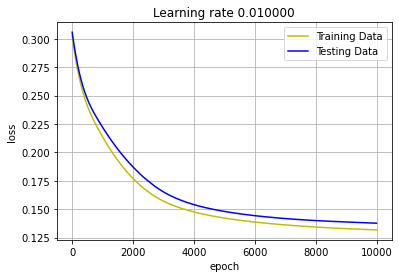

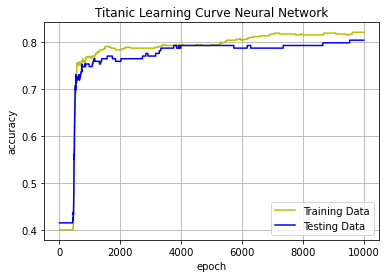

In [8]:
dims=7
test=DataProcess()
ds,y=test.get_data(2)
#ds=test.dimReduction(ds, 3, 2, 1000, .01)


ds=pd.DataFrame(data=ds)
NN=NeuralNetwork(ds,y)
NN.run_NN(dims,dims-2)


#NN=NeuralNetwork(ds,y)
#NN.run_NN()

Producing best fit model for NN 193.5348 seconds
accuracy:  0.8352059925093633
f1_score:  0.7832512315270936


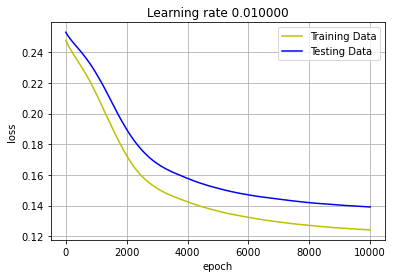

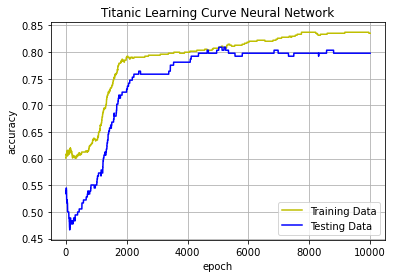

In [9]:
dims=8
test=DataProcess()
ds,y=test.get_data(2)
labels=cluster.KMeans(n_clusters=2).fit(ds).labels_
ds['cluster']=labels

ds=pd.DataFrame(data=ds)
NN=NeuralNetwork(ds,y)
NN.run_NN(dims,dims-2)

Producing best fit model for NN 177.8079 seconds
accuracy:  0.8239700374531835
f1_score:  0.7729468599033816


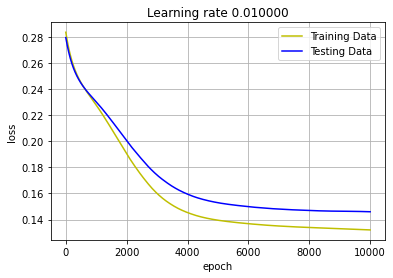

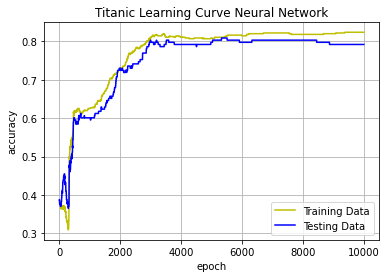

In [12]:
dims=8
test=DataProcess()
ds,y=test.get_data(2)

em=mixture.GaussianMixture(n_components=2, covariance_type='full',max_iter=1000,init_params='kmeans')
em.fit(ds)
labels=em.predict(ds)    
ds['cluster']=labels

ds=pd.DataFrame(data=ds)
NN=NeuralNetwork(ds,y)
NN.run_NN(dims,dims-2)


In [21]:
dat=[]
temp=["Accuracy",82.0, 83.5, 82.4] 
dat.append(temp)
temp=["F1 Score",75.7, 78.3, 77.3]
dat.append(temp)
temp=["Run Time", 177, 193,187]
dat.append(temp)
df_res=pd.DataFrame(dat,columns=["","Orignal DS", "K-Means","EM"])
df_res

,,Orignal DS,K-Means,EM
0,Accuracy,82.0,83.5,82.4
1,F1 Score,75.7,78.3,77.3
2,Run Time,177.0,193.0,187.0


In [239]:
#test=DataProcess()
#ds,y=test.get_data(2)
#ds=test.dimReduction(ds, 1, 2, 1000, .01)
#ds=pd.DataFrame(data=ds)

#NN=NeuralNetwork(ds,y)
#NN.run_NN()

Producing best fit model for NN 171.0135 seconds
accuracy:  0.6797752808988764
f1_score:  0.5210084033613445


In [248]:
#test=DataProcess()
#ds,y=test.get_data(2)
#ds=test.dimReduction(ds, 4, 6, 1000, .01)
#ds=pd.DataFrame(data=ds)

#NN=NeuralNetwork(ds,y)
#NN.run_NN()

Producing best fit model for NN 176.5027 seconds
accuracy:  0.7940074906367042
f1_score:  0.7208121827411167


In [234]:
#df=pd.DataFrame(data=ds)

In [3]:
#df

In [198]:
#test=DataProcess()
#ds,y=test.get_data(2)
#ds=test.dimReduction(ds, 3, 2, 1000, .01)
#test.EMOutput(ds,y,"Titanic","ICA")    